In [1]:
import sys
sys.path.append("..")

from src.data.make_dataset import *
from src.features.build_features import *
from src.models.train_model import *
from src.models.predict_model import *
from src.visualization.visualize import *

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

import pickle

from kafka import KafkaConsumer

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data loading and Visualization

In [2]:
# make dataset
path="../src/"
model_path="../src/models/Saved_models/"
output_path="../src/models/csv_predictions/"

df = pd.read_csv(path+"data/training_dataset.csv")

In [3]:
df.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Label
0,58:50.7,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
1,58:50.3,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
2,58:49.9,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,1
3,58:49.5,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,1
4,58:49.1,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536138 entries, 0 to 536137
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         536138 non-null  object 
 1   FQDN_count        536138 non-null  int64  
 2   subdomain_length  536138 non-null  int64  
 3   upper             536138 non-null  int64  
 4   lower             536138 non-null  int64  
 5   numeric           536138 non-null  int64  
 6   entropy           536138 non-null  float64
 7   special           536138 non-null  int64  
 8   labels            536138 non-null  int64  
 9   labels_max        536138 non-null  int64  
 10  labels_average    536138 non-null  float64
 11  longest_word      536124 non-null  object 
 12  sld               536138 non-null  object 
 13  len               536138 non-null  int64  
 14  subdomain         536138 non-null  int64  
 15  Label             536138 non-null  int64  
dtypes: float64(2), int64

In [5]:
df.describe()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Label
count,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000,536138.000000
mean,22.345262,6.100633,0.849604,10.412959,6.539344,2.485026,4.543355,4.806201,8.240375,4.794970,12.587228,0.757902,0.549025
std,5.968281,3.883699,4.951571,3.226364,4.482443,0.407780,2.193396,1.796751,4.408849,4.579084,4.173231,0.428354,0.497591
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,1.500000,2.000000,0.000000,0.000000
25%,19.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,11.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,29.000000,32.000000,34.000000,12.000000,4.368167,8.000000,7.000000,32.000000,32.000000,35.000000,1.000000,1.000000


## visualizing

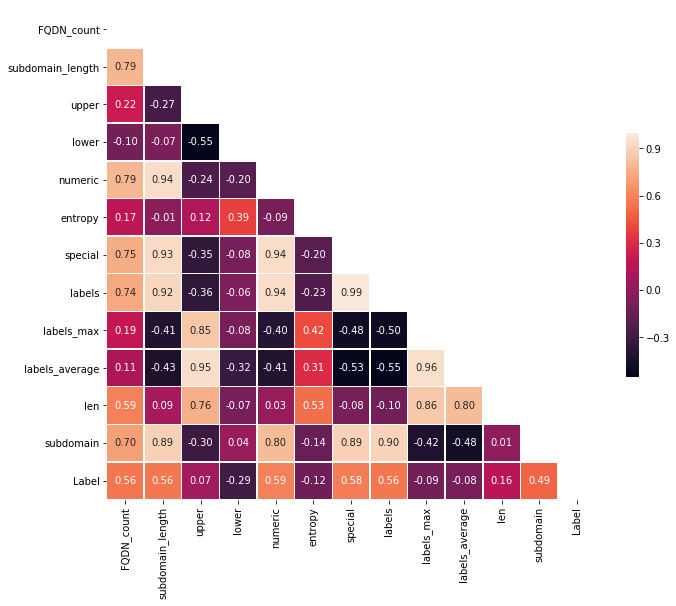

In [6]:
corr_matrix(df)

## Data split

In [7]:
X_train,X_test,y_train,y_test = prepare_data(df)

# Modeling

## Random Forest

In [8]:
clf = Model_trainer("RF")
clf.fit(X_train,y_train)

#predictions
rf_acc,rf_f1 =Model_predict(clf).predict(X_test,y_test) # confusion matrix -> y-axis True labels, X-axis predicted labels

Accuracy Score over test set : 0.8212686984742791
F1 Score over test set : 0.8598609211959901
Confusion Matrix :
 [[29267 19090]
 [   75 58796]]


In [11]:
#save model
with open(r""+model_path+"random_forest_acc_82.sav","wb") as file:
    pickle.dump(clf, file)

In [12]:
# laod model
with open(r""+model_path+"random_forest_acc_82.sav","rb") as file:
    model = pickle.load(file)

In [ ]:
# consume kafka
consumer = KafkaConsumer("ml-raw-dns",bootstrap_servers="localhost:9092",auto_offset_reset="earliest")

In [ ]:
# feature extraction and saveing to dataframe
df_generated =pd.DataFrame(columns=['URL','FQDN_count','subdomain_length','upper','lower','numeric','entropy','special','labels','labels_max','labels_average','longest_word','sld','len','subdomain','Confidence',"Predicted_Label"])

for message in consumer:

    url=message.value.decode("utf-8")

    # extracting features
    record = generate_attribute(url)


    tmp_record=record.to_dict('records')
    tmp_record[0]["URL"]=url

    # predicting record label
    tmp_record[0]["Predicted_Label"]=model.predict(reformat_record(record))[0]
    # predicted record confidence
    tmp_record[0]["Confidence"]=np.max(model.predict_proba(reformat_record(record)))

    df_generated=df_generated.append(tmp_record[0],ignore_index=True)

    # when limit reaches break to wait end in infinity loop
    if len(df_generated)>=100000:
        break
df_generated.to_csv(r""+output_path+"predcitions.csv",index=False)

## Gradient Boosting

In [9]:
clf = Model_trainer("GB")
clf.fit(X_train,y_train)

#predictions
gb_acc,gb_f1 =Model_predict(clf).predict(X_test,y_test) # confusion matrix -> y-axis True labels, X-axis predicted labels

Accuracy Score over test set : 0.8215484761442907
F1 Score over test set : 0.8601375600271904
Confusion Matrix :
 [[29254 19103]
 [   32 58839]]


## KNN

In [10]:
clf = Model_trainer("KNN")
clf.fit(X_train,y_train)

#predictions
knn_acc,knn_f1 =Model_predict(clf).predict(X_test,y_test) # confusion matrix -> y-axis True labels, X-axis predicted labels

Accuracy Score over test set : 0.8179020405118066
F1 Score over test set : 0.8564201361824787
Confusion Matrix :
 [[29468 18889]
 [  637 58234]]


## SVM

In [8]:
# Too much time to run with same output as others 

clf = Model_trainer("SVC")
clf.fit(X_train,y_train)

#predictions
svc_acc,svc_f1 =Model_predict(clf).predict(X_test,y_test) # confusion matrix -> y-axis True labels, X-axis predicted labels

## Keras DNN

In [11]:
clf = Model_trainer("DNN")
clf.fit(X_train,y_train)

#predictions
dnn_acc,dnn_f1 = Model_predict(clf).predict(X_test,y_test) # confusion matrix -> y-axis True labels, X-axis predicted labels

Train on 386019 samples, validate on 42891 samples
Epoch 1/1
386019/386019 [==============================] - 3s 9us/step - loss: 0.4219 - accuracy: 0.8180 - val_loss: 0.4128 - val_accuracy: 0.8206
Accuracy Score over test set : 0.8201682396389003
F1 Score over test set : 0.8588391177353352
Confusion Matrix :
 [[29285 19072]
 [  211 58660]]


# Models Comparison 

[0.8212686984742791, 0.8179020405118066, 0.8215484761442907, 0.8201682396389003]


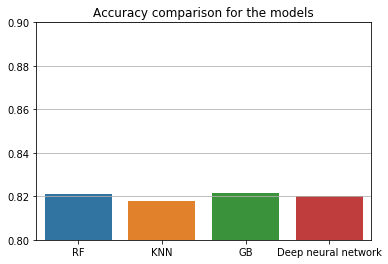

In [37]:
# svm discarded due to long time to run
models_accuacy_comaprison={"RF":rf_acc,
                           "KNN":knn_acc,
                           "GB":gb_acc,
                           "Deep neural network":dnn_acc}
plt.ylim(0.8,0.9)
plt.grid()
plt.title("Accuracy comparison for the models")

print(list(models_accuacy_comaprison.values()))
sns.barplot(list(models_accuacy_comaprison.keys()),list(models_accuacy_comaprison.values()))

[0.8598609211959901, 0.8564201361824787, 0.8601375600271904, 0.8588391177353352]


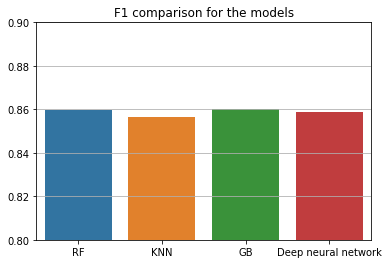

In [36]:
# svm discarded due to long time to run
models_accuacy_comaprison={"RF":rf_f1,
                           "KNN":knn_f1,
                           "GB":gb_f1,
                           "Deep neural network":dnn_f1}
plt.ylim(0.8,0.9)
plt.grid()
plt.title("F1 comparison for the models")

print(list(models_accuacy_comaprison.values()))
sns.barplot(list(models_accuacy_comaprison.keys()),list(models_accuacy_comaprison.values()))